# This tutorial shows how to export YoloNAS-R model to ONNX

From this tutorial you will learn:

* How to export YoloNAR-R Oriented Bounding Box (OBB) Detection model to ONNX
* How to enable FP16 / INT8 quantization and export a model with calibration
* How to customize NMS parameters and number of detections per image

### Currently supported models

- YoloNAS-R

### Supported features

- Exporting a model with preprocessing (e.g. normalizing/standardizing image according to normalization parameters during training)
- Exporting a model with postprocessing (e.g. predictions decoding and NMS) - you obtain the ready-to-consume bounding box outputs
- FP16 / INT8 quantization support with calibration
- Pre- and post-processing steps can be customized by the user if needed
- Customising input image shape and batch size
- Customising NMS parameters and number of detections per image
- Customising output format (flat or batched)

In [1]:
!pip install -qq super_gradients==3.7.1

### Minimalistic export example

Let start with the most simple example of exporting a model to ONNX format.
We will use YoloNAS-R Small model in this example. All models that suports new export API now expose a `export()` method that can be used to export a model. There is one mandatory argument that should be passed to the `export()` method - the path to the output file. Currently, only `.onnx` format is supported, but we may add support for CoreML and other formats in the future.

In [2]:
from super_gradients.training.processing.defaults import default_yolo_nas_r_dota_processing_params
from super_gradients.common.object_names import Models
from super_gradients.training import models

model = models.get(Models.YOLO_NAS_R_S,
                   checkpoint_path="C:/Develop/GitHub/Deci/super-gradients/checkpoints/dota_yolo_nas_r_s/ckpt_best.pth",
                   num_classes=18)
model.set_dataset_processing_params(**default_yolo_nas_r_dota_processing_params())

export_result = model.export("yolo_nas_r_s.onnx")

A lot of work just happened under the hood:

* A model was exported to ONNX format using default batch size of 1 and input image shape that was used during training
* A preprocessing and postprocessing steps were attached to ONNX graph
* For pre-processing step, the normalization parameters were extracted from the model itself (to be consistent with the image normalization and channel order used during training)
* For post-processing step, the NMS parameters were also extracted from the model and NMS module was attached to the graph
* ONNX graph was checked and simplified to improve compatibility with ONNX runtimes.

A returned value of `export()` method is an instance of `ModelExportResult` class.
First of all it serves the purpose of storing all the information about the exported model in a single place.
It also provides a convenient way to get an example of running the model and getting the output:

In [3]:
export_result

Model exported successfully to yolo_nas_r_s.onnx
Model expects input image of shape [1, 3, 1024, 1024]
Input image dtype is torch.uint8
Exported model already contains preprocessing (normalization) step, so you don't need to do it manually.
Preprocessing steps to be applied to input image are:
Sequential(
  (0): CastTensorTo(dtype=torch.float32)
  (1): ChannelSelect(channels_indexes=tensor([2, 1, 0]))
  (2): ApplyMeanStd(mean=[0.], scale=[255.])
)

Exported model contains postprocessing (NMS) step with the following parameters:
    num_pre_nms_predictions=1000
    max_predictions_per_image=1000
    nms_threshold=0.25
    confidence_threshold=0.1
    output_predictions_format=batch

Exported model is in ONNX format and can be used with ONNXRuntime
To run inference with ONNXRuntime, please use the following code snippet:

    import onnxruntime
    import numpy as np
    session = onnxruntime.InferenceSession("yolo_nas_r_s.onnx", providers=["CUDAExecutionProvider", "CPUExecutionProvider"

That's it. You can now use the exported model with any ONNX-compatible runtime or accelerator.


In [4]:
import cv2
import numpy as np
from super_gradients.training.utils.media.image import load_image
import onnxruntime

image = load_image("h:/DOTA/DOTA-v2.0/val/images/P1924.png")
image = cv2.resize(image, (export_result.input_image_shape[1], export_result.input_image_shape[0]))
image_bchw = np.transpose(np.expand_dims(image, 0), (0, 3, 1, 2))

session = onnxruntime.InferenceSession(export_result.output,
                                       providers=["CUDAExecutionProvider", "CPUExecutionProvider"])
inputs = [o.name for o in session.get_inputs()]
outputs = [o.name for o in session.get_outputs()]
result = session.run(outputs, {inputs[0]: image_bchw})

result[0].shape, result[1].shape, result[2].shape, result[3].shape

((1, 1), (1, 1000, 5), (1, 1000), (1, 1000))

In the next section we unpack the result of prediction and show how to use it.

## Output format for detection models

If `preprocessing=True` (default value) then all models will be exported with NMS. If `preprocessing=False` models will be exported without NMS and raw model outputs will be returned. In this case, you will need to apply NMS yourself. This is useful if you want to use a custom NMS implementation that is not ONNX-compatible. In most cases you will want to use default `preprocessing=True`. It is also possible to pass a custom `nn.Module` as a `postprocessing` argument to the `export()` method. This module will be attached to the exported ONNX graph instead of the default NMS module. We encourage users to read the documentation of the `export()` method to learn more about the advanced options.

When exporting an object detection model with postprocessing enabled, the prediction format can be one of two:

* A "flat" format - `DetectionOutputFormatMode.FLAT_FORMAT`
* A "batched" format - `DetectionOutputFormatMode.BATCH_FORMAT`

You can select the desired output format by setting `export(..., output_predictions_format=DetectionOutputFormatMode.BATCH_FORMAT)`.

### Flat format

A detection results returned as a single tensor of shape `[N, 8]`, where `N` is the number of detected objects in the entire batch. Each row in the tensor represents a single detection result and has the following format:

`[batch_index, cx, cy, w, h, r, class score, class index]`

When exporting a model with batch size of 1 (default mode) you can ignore the first column as all boxes will belong to the single sample. In case you export model with batch size > 1 you have to iterate over this array like so:

```python
for sample_index, pred_boxes_cxcywhr, pred_scores, pred_labels, in iterate_over_obb_detection_predictions_in_flat_format(flat_predictions, export_result.batch_size):
    # do something with the detection predictions
```

### Batch format

A second supported format is so-called "batch". It matches with output format of TensorRT's NMS implementation. The return value in this case is tuple of 4 tensors:

* `num_predictions` - [B, 1] - A number of predictions per sample
* `pred_boxes` - [B, N, 5] - A coordinates of the predicted boxes in `[СX, СН, W, H, R]` format
* `pred_scores` - [B, N] - A scores of the predicted boxes
* `pred_classes` - [B, N] - A class indices of the predicted boxes

Here `B` corresponds to batch size and `N` is the maximum number of detected objects per image.
In order to get the actual number of detections per image you need to iterate over `num_predictions` tensor and get the first element of each row.

Now when you're familiar with the output formats, let's see how to use them.
To start, it's useful to take a look at the values of the predictions with a naked eye:


In [5]:
num_predictions, pred_boxes, pred_scores, pred_classes = result
num_predictions

array([[49]], dtype=int64)

In [6]:
np.set_printoptions(threshold=50, edgeitems=3)
pred_boxes, pred_boxes.shape

(array([[[567.8987    , 327.9787    , 124.2696    ,  33.621662  ,
            0.93059605],
         [380.41522   , 264.9621    , 126.8444    ,  33.090794  ,
            0.92384446],
         [502.266     , 362.20212   , 122.46783   ,  32.905663  ,
            0.92471427],
         ...,
         [ -1.        ,  -1.        ,  -1.        ,  -1.        ,
           -1.        ],
         [ -1.        ,  -1.        ,  -1.        ,  -1.        ,
           -1.        ],
         [ -1.        ,  -1.        ,  -1.        ,  -1.        ,
           -1.        ]]], dtype=float32),
 (1, 1000, 5))

In [7]:
np.set_printoptions(threshold=50, edgeitems=5)
pred_scores, pred_scores.shape

(array([[ 0.9518181,  0.9476131,  0.9467566,  0.9455704,  0.9416076, ...,
         -1.       , -1.       , -1.       , -1.       , -1.       ]],
       dtype=float32),
 (1, 1000))

In [8]:
np.set_printoptions(threshold=50, edgeitems=10)
pred_classes, pred_classes.shape

(array([[ 9,  9,  9,  9,  9,  9,  9,  9,  9,  9, ..., -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1]], dtype=int64),
 (1, 1000))

### Visualizing predictions

For sake of this tutorial we will use a simple visualization function that is tailored for batch_size=1 only.
You can use it as a starting point for your own visualization code.

In [9]:
from super_gradients.inference import iterate_over_obb_detection_predictions_in_batched_format
from super_gradients.training.utils.visualization.utils import generate_color_mapping
from super_gradients.training.utils.visualization.obb import OBBVisualization
from super_gradients.training.datasets.datasets_conf import DOTA2_DEFAULT_CLASSES_LIST
import matplotlib.pyplot as plt

DOTA2_CLASS_COLORS = generate_color_mapping(len(DOTA2_DEFAULT_CLASSES_LIST))


def show_predictions_from_batch_format(image, predictions):
    image = image.copy()

    _, pred_boxes, pred_scores, pred_classes = next(iter(iterate_over_obb_detection_predictions_in_batched_format(predictions)))

    image = OBBVisualization.draw_obb(
        image=image,
        rboxes_cxcywhr=pred_boxes,
        scores=pred_scores,
        labels=pred_classes,
        class_names=DOTA2_DEFAULT_CLASSES_LIST,
        class_colors=DOTA2_CLASS_COLORS,
    )

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.tight_layout()
    plt.show()

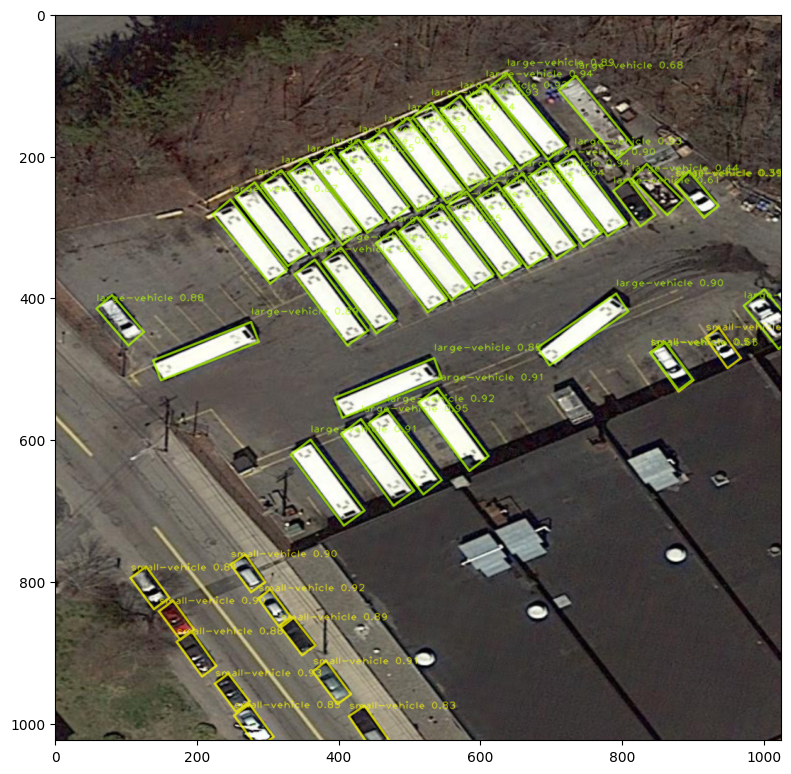

In [10]:
show_predictions_from_batch_format(image, result)

### Changing the output format

You can explicitly specify output format of the predictions by setting the `output_predictions_format` argument of `export()` method. Let's see how it works:


In [11]:
from super_gradients.conversion import DetectionOutputFormatMode

export_result = model.export("yolo_nas_s_r_flat_format.onnx",
                             output_predictions_format=DetectionOutputFormatMode.FLAT_FORMAT)
export_result

Model exported successfully to yolo_nas_s_r_flat_format.onnx
Model expects input image of shape [1, 3, 1024, 1024]
Input image dtype is torch.uint8
Exported model already contains preprocessing (normalization) step, so you don't need to do it manually.
Preprocessing steps to be applied to input image are:
Sequential(
  (0): CastTensorTo(dtype=torch.float32)
  (1): ChannelSelect(channels_indexes=tensor([2, 1, 0]))
  (2): ApplyMeanStd(mean=[0.], scale=[255.])
)

Exported model contains postprocessing (NMS) step with the following parameters:
    num_pre_nms_predictions=1000
    max_predictions_per_image=1000
    nms_threshold=0.25
    confidence_threshold=0.1
    output_predictions_format=flat

Exported model is in ONNX format and can be used with ONNXRuntime
To run inference with ONNXRuntime, please use the following code snippet:

    import onnxruntime
    import numpy as np
    session = onnxruntime.InferenceSession("yolo_nas_s_r_flat_format.onnx", providers=["CUDAExecutionProvider",

Now we exported a model that produces predictions in `flat` format. Let's run the model like before and see the result:

In [12]:
session = onnxruntime.InferenceSession(export_result.output,
                                       providers=["CUDAExecutionProvider", "CPUExecutionProvider"])
inputs = [o.name for o in session.get_inputs()]
outputs = [o.name for o in session.get_outputs()]
result = session.run(outputs, {inputs[0]: image_bchw})
result[0].shape

(49, 8)

In [13]:
from super_gradients.inference import iterate_over_obb_detection_predictions_in_flat_format


def show_predictions_from_flat_format(image, predictions):
    image = image.copy()
    _, pred_boxes, pred_scores, pred_classes = next(
        iter(iterate_over_obb_detection_predictions_in_flat_format(predictions, batch_size=1)))

    image = OBBVisualization.draw_obb(
        image=image,
        rboxes_cxcywhr=pred_boxes,
        scores=pred_scores,
        labels=pred_classes,
        class_names=DOTA2_DEFAULT_CLASSES_LIST,
        class_colors=DOTA2_CLASS_COLORS,
    )

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.tight_layout()
    plt.show()

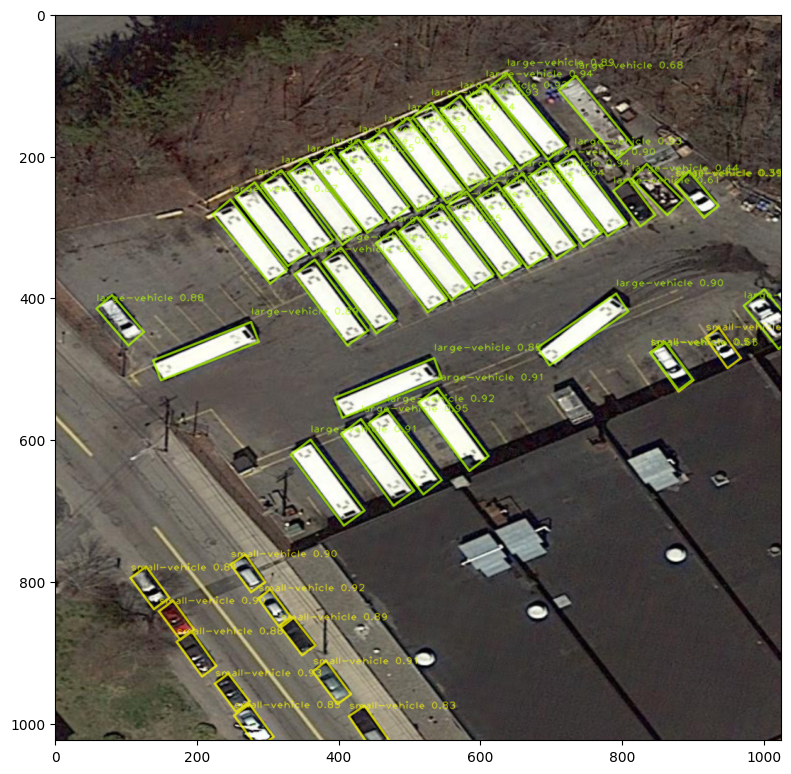

In [14]:
show_predictions_from_flat_format(image, result)

### Changing postprocessing settings

You can control a number of parameters in the NMS settings as well as maximum number of detections per image before and after NMS step:

* IOU threshold for NMS - `nms_iou_threshold`
* Score threshold for NMS - `nms_score_threshold`
* Maximum number of detections per image before NMS - `max_detections_before_nms`
* Maximum number of detections per image after NMS - `max_detections_after_nms`

For sake of demonstration, let's export a model that would produce at most one detection per image with confidence threshold above 0.8 and NMS IOU threshold of 0.5. Let's use at most 100 predictions per image before NMS step:

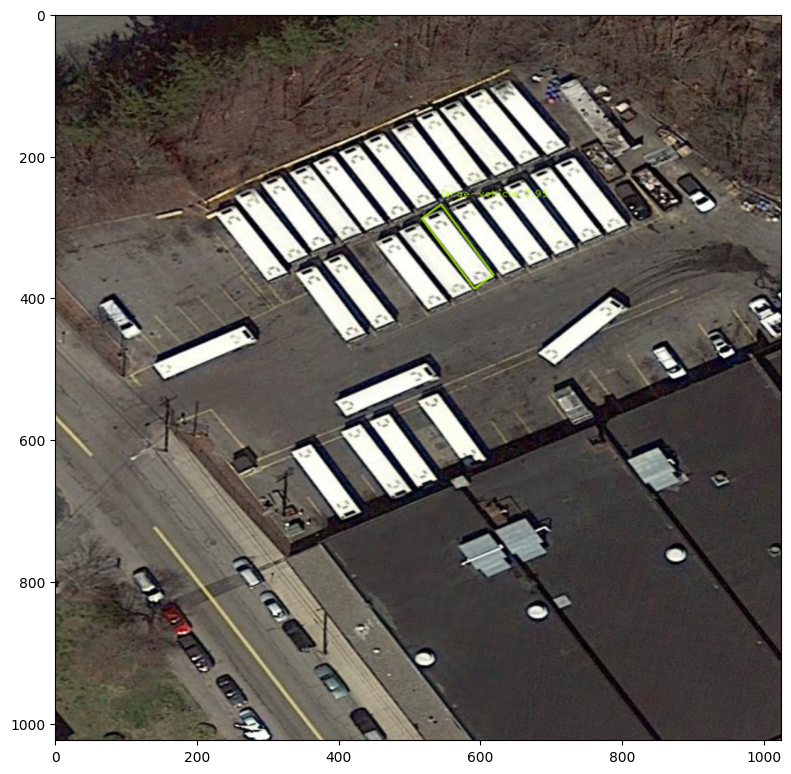

In [15]:
export_result = model.export(
    "yolo_nas_s_top_1.onnx",
    confidence_threshold=0.8,
    nms_threshold=0.15,
    num_pre_nms_predictions=100,
    max_predictions_per_image=1,
    output_predictions_format=DetectionOutputFormatMode.FLAT_FORMAT
)

session = onnxruntime.InferenceSession(export_result.output,
                                       providers=["CUDAExecutionProvider", "CPUExecutionProvider"])
inputs = [o.name for o in session.get_inputs()]
outputs = [o.name for o in session.get_outputs()]
result = session.run(outputs, {inputs[0]: image_bchw})

show_predictions_from_flat_format(image, result)

### Export of quantized model

You can export a model with quantization to FP16 or INT8. To do so, you need to specify the `quantization_mode` argument of `export()` method.

Important notes:
* Quantization to FP16 requires CUDA / MPS device available and would not work on CPU-only machines.

Let's see how it works:

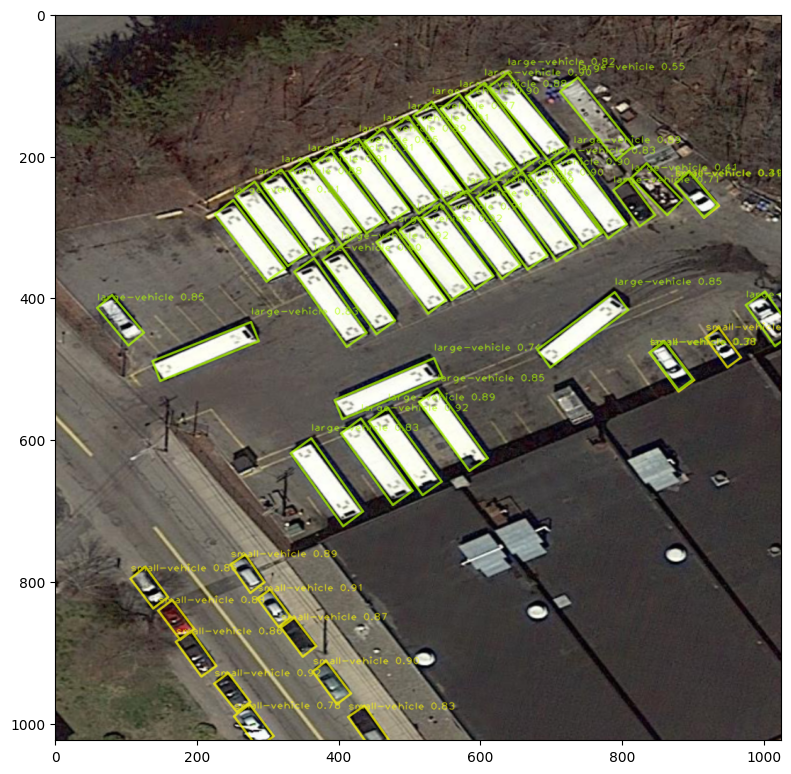

In [16]:
from super_gradients.conversion.conversion_enums import ExportQuantizationMode

export_result = model.export(
    "yolo_nas_r_s_int8.onnx",
    output_predictions_format=DetectionOutputFormatMode.FLAT_FORMAT,
    quantization_mode=ExportQuantizationMode.INT8
)

session = onnxruntime.InferenceSession(export_result.output,
                                       providers=["CUDAExecutionProvider", "CPUExecutionProvider"])
inputs = [o.name for o in session.get_inputs()]
outputs = [o.name for o in session.get_outputs()]
result = session.run(outputs, {inputs[0]: image_bchw})

show_predictions_from_flat_format(image, result)

### Advanced INT-8 quantization options

When quantizing a model using `quantization_mode==ExportQuantizationMode.INT8` you can pass a DataLoader to export() function to collect correct statistics of activations to prodice a more accurate quantized model.
We expect the DataLoader to return either a tuple of tensors or a single tensor. In case a tuple of tensors is returned by data-loader the first element will be used as input image.
You can use existing data-loaders from SG here as is.

**Important notes**
* A `calibration_loader` should use same image normalization parameters that were used during training.

In the example below we use a dummy data-loader for sake of showing how to use this feature. You should use your own data-loader here.

Calibrating:  25%|██▌       | 4/16 [00:07<00:23,  1.97s/it]


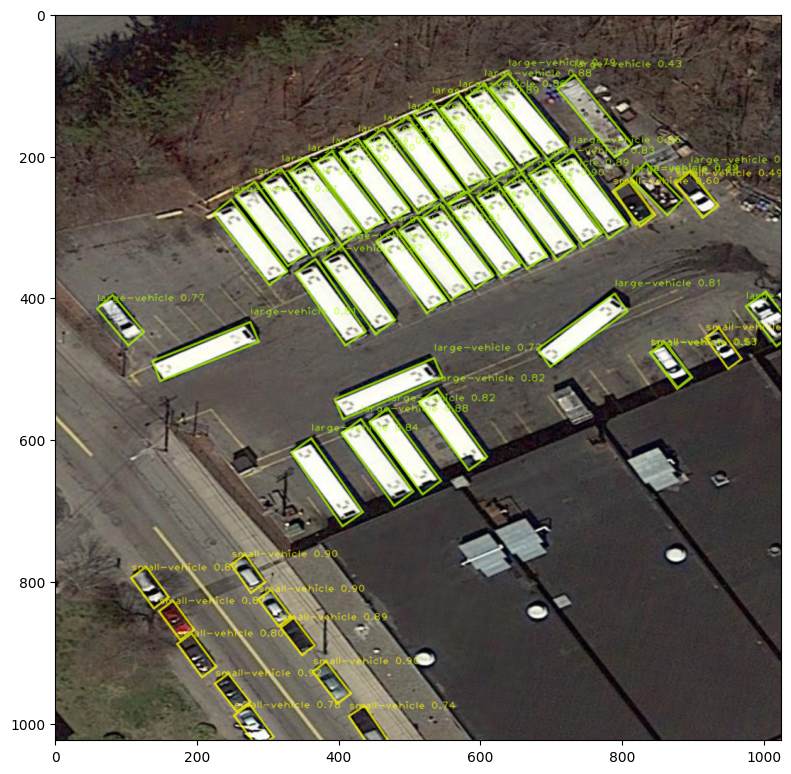

In [17]:
import torch
from torch.utils.data import DataLoader
from super_gradients.conversion import ExportQuantizationMode

# THIS IS ONLY AN EXAMPLE. YOU SHOULD USE YOUR OWN DATA-LOADER HERE
dummy_calibration_dataset = [torch.randn((3, 640, 640), dtype=torch.float32) for _ in range(32)]
dummy_calibration_loader = DataLoader(dummy_calibration_dataset, batch_size=8, num_workers=0)
# THIS IS ONLY AN EXAMPLE. YOU SHOULD USE YOUR OWN DATA-LOADER HERE

export_result = model.export(
    "yolo_nas_r_s_int8_with_calibration.onnx",
    output_predictions_format=DetectionOutputFormatMode.FLAT_FORMAT,
    quantization_mode=ExportQuantizationMode.INT8,
    calibration_loader=dummy_calibration_loader
)

session = onnxruntime.InferenceSession(export_result.output,
                                       providers=["CUDAExecutionProvider", "CPUExecutionProvider"])
inputs = [o.name for o in session.get_inputs()]
outputs = [o.name for o in session.get_outputs()]
result = session.run(outputs, {inputs[0]: image_bchw})

show_predictions_from_flat_format(image, result)

### Limitations

* Dynamic batch size / input image shape is not supported yet. You can only export a model with a fixed batch size and input image shape.
* TensorRT of version 8.6 or higher is required.
* Quantization to FP16 requires CUDA / MPS device available.

## Legacy low-level export API

The .export() API is a new high-level API that is recommended for most use-cases.
However old low-level API is still available for advanced users:

* https://docs.deci.ai/super-gradients/docstring/training/models.html#training.models.conversion.convert_to_onnx
* https://docs.deci.ai/super-gradients/docstring/training/models.html#training.models.conversion.convert_to_coreml
